<a href="https://colab.research.google.com/github/nehana4sph/TCS-iON_RIO-125-Forecasting-System/blob/main/Sales_Forecasting_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas==1.2.0
!pip install xlrd==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 4.4 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 3.2 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [ ]:
#Importing required libraries
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
import xlrd

Mounted at /content/gdrive


In [ ]:
df = pd.read_excel('/content/gdrive/MyDrive/Internship/Superstore.xls')
print(df.head())
print(df.tail())

   Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
2       3  CA-2016-138688 2016-06-12 2016-06-16    Second Class    DV-13045   
3       4  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   
4       5  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   South  FUR-BO-10

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64


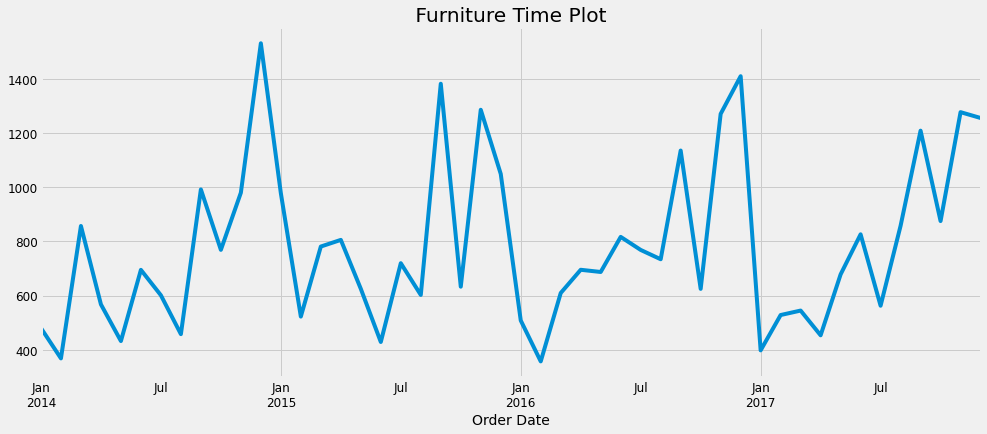

In [ ]:
#data preprocessing for category furniture
furniture = df.loc[df['Category'] == 'Furniture']
furniture['Order Date'].min(), furniture['Order Date'].max()
cols = ['Row ID','Order ID', 'Ship Date', 'Ship Mode', 'Customer ID','Customer Name','Segment','Country','City','State','Postal Code','Region','Product ID',
        'Category','Sub-Category','Product Name','Quantity','Discount','Profit']
furniture.drop(cols, axis=1, inplace = True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
furniture.index
y = furniture['Sales'].resample('MS').mean()
print(y['2017':])
y.plot(figsize=(15,6))
plt.title(' Furniture Time Plot ')
plt.show()




In [ ]:
#size of each category
df.groupby(['Category']).size()


Category
Furniture          2121
Office Supplies    6026
Technology         1847
dtype: int64

Office Supplies 



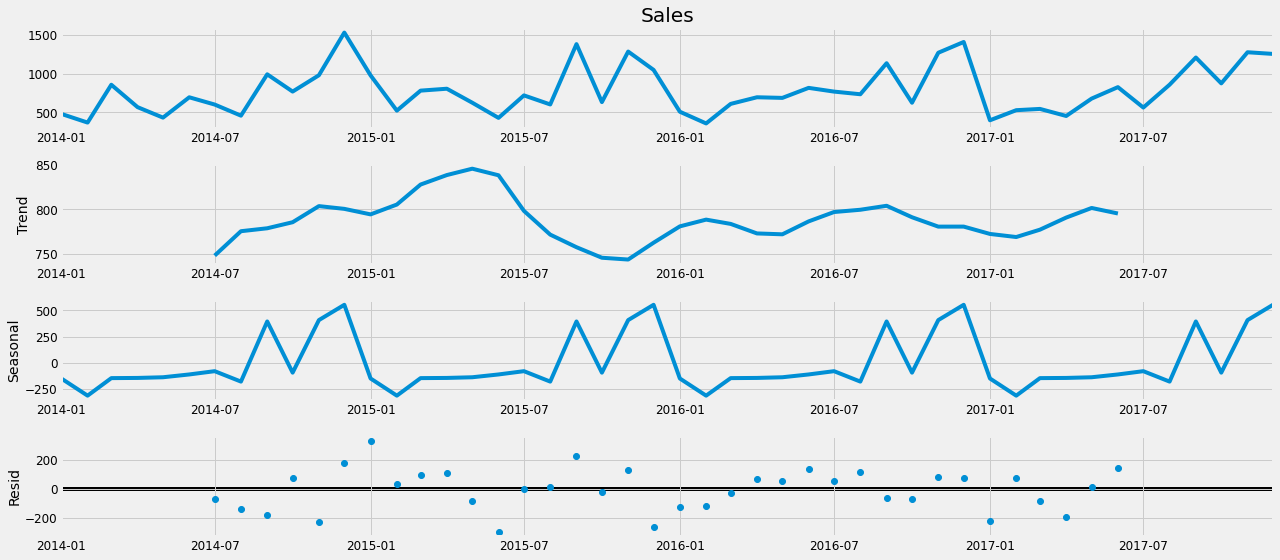

In [ ]:
#Time Series Decomposition
from pylab import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

##Fitting ARIMA##

Identification of p,d,q

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA......')
print('SARIMAX: {} x {}'.format(pdq[1],seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1],seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2],seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2],seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA......
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
          continue
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1619.796546928274
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:477.71701309202774


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:302.2702899793669
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:497.2314433418337


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1516.7645378946113
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:304.248828030213
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:720.9252270758095
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:2676.7726957355044


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:466.5607429809162
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:291.62613896733006


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:499.5817476995887


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:2584.6216938524685
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:319.9884876946866
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:291.8725576435603
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1327.9694547881852


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:486.6378567198382
ARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:304.96712281679663
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:497.78896630044073


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:1493.8184751015256
ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:319.7714068109211
ARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:306.9113200151421
ARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:649.9056176816888


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:2182.4585779572526
ARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:458.8705548482537
ARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:279.58062333599605
ARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:486.1832977442641
ARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:1052.5933467107616
ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:310.75743684172403
ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:281.55766214612396
ARIMA(1, 0, 0)x(0, 0, 0, 12) - AIC:692.1645522067712


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12) - AIC:1185.8152346218792
ARIMA(1, 0, 0)x(0, 1, 0, 12) - AIC:479.46321478521355
ARIMA(1, 0, 0)x(0, 1, 1, 12) - AIC:304.20776751609714
ARIMA(1, 0, 0)x(1, 0, 0, 12) - AIC:480.9259367935197


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12) - AIC:1292.8399847519806
ARIMA(1, 0, 0)x(1, 1, 0, 12) - AIC:304.4664675084599
ARIMA(1, 0, 0)x(1, 1, 1, 12) - AIC:304.58426921438075
ARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:665.779444218626


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12) - AIC:470.8931152262245
ARIMA(1, 0, 1)x(0, 1, 0, 12) - AIC:468.3685195814191
ARIMA(1, 0, 1)x(0, 1, 1, 12) - AIC:293.34221939659176
ARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:482.576332387679


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:2557.724422083582
ARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:306.01560021316396
ARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:293.7513188123627
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:671.2513547541902


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:1145.7548309218187
ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:479.2003422281134
ARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:300.2130611619099
ARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:475.3403658786717


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:1248.7678997991263
ARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:300.62709013454264
ARIMA(1, 1, 0)x(1, 1, 1, 12) - AIC:302.3264992507484
ARIMA(1, 1, 1)x(0, 0, 0, 12) - AIC:649.0318019835265


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:2559.529647245557
ARIMA(1, 1, 1)x(0, 1, 0, 12) - AIC:460.4762687609924
ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:281.38730069394046
ARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:469.52503546608364


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:2209.602452666275
ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:297.7875439534141
ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:283.3661017139785
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0836      0.243      0.344      0.731      -0.392       0.560
ma.L1         -1.0000   1490.269     -0.001      0.999   -2921.873    2919.873
ma.S.L12      -1.0001   1490.288     -0.001      0.999   -2921.910    2919.910
sigma2       2.68e+04      0.037    7.3e+05      0.000    2.68e+04    2.68e+04


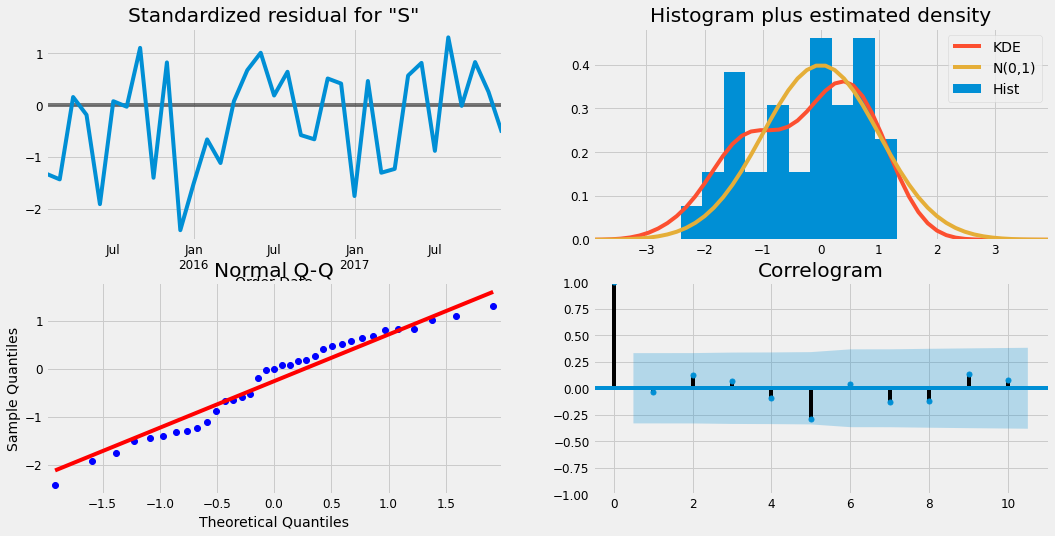

In [ ]:
#Plotting Diagnostic Plots
results.plot_diagnostics(figsize=(16, 8))
plt.show()

It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

###Prediction###

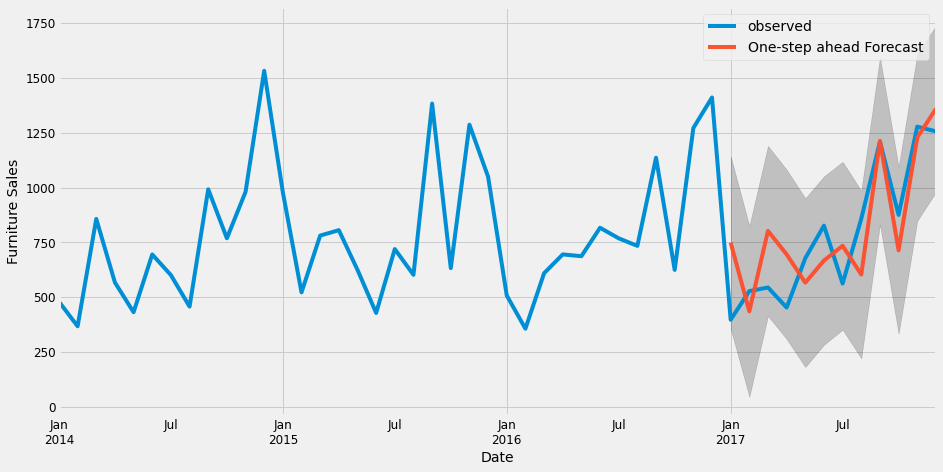

The Mean Squared Error of our forecasts is 35686.32
The Root Mean Squared Error of our forecasts is 188.91


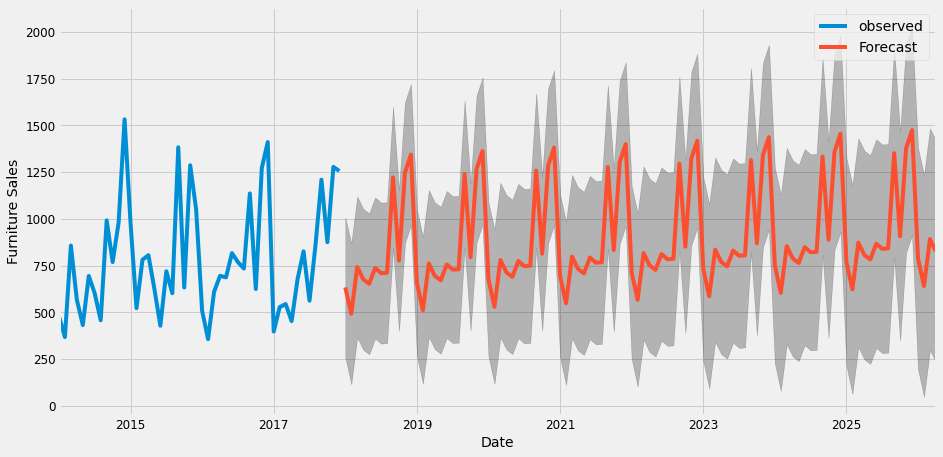

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic = False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label = 'observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast' , alpha = 7, figsize=(14,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha= .2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01' :]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
pred_uc = results.get_forecast(steps = 100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize = (14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

1. The Mean Squared Error of our forecasts is 35686.32
2. The Root Mean Squared Error of our forecasts is 188.91

##Comparing the model with other Categories like Office Supplies.##
So, now we have Furniture and Office Supplies.

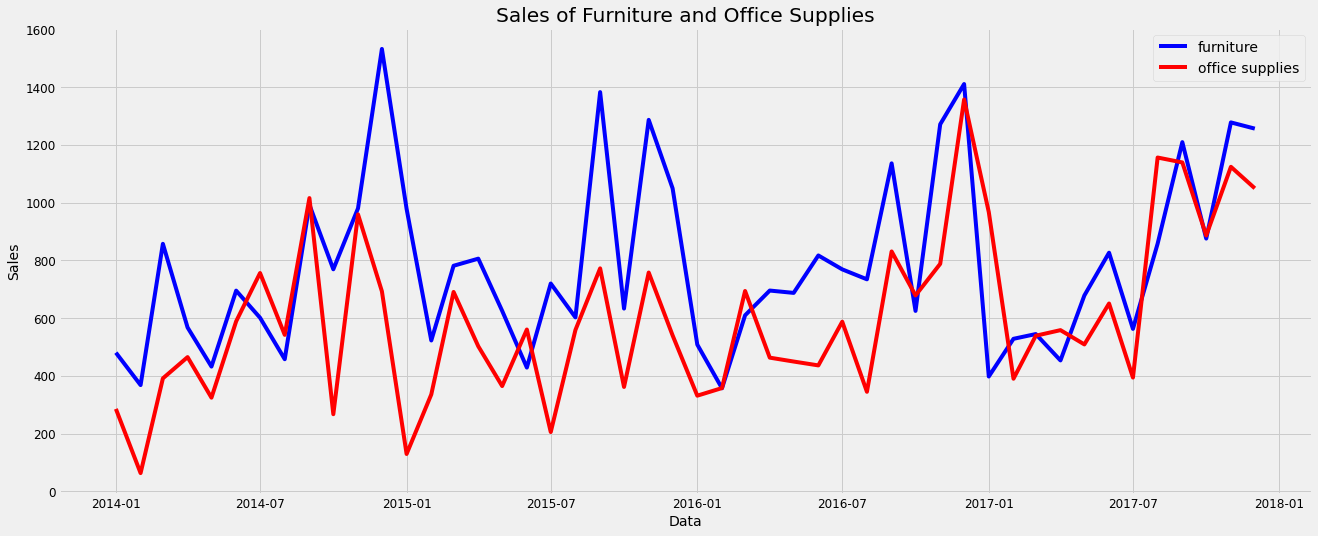

In [ ]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape
cols = ['Row ID','Order ID', 'Ship Date', 'Ship Mode', 'Customer ID','Customer Name','Segment','Country','City','State','Postal Code','Region','Product ID',
        'Category','Sub-Category','Product Name','Quantity','Discount','Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date':y_office.index, 'Sales': y_office.values})

store = furniture.merge(office,how= 'inner',on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace = True)
store.head()

plt.figure(figsize=(20,8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Data')
plt.ylabel('Sales')
plt.title('Sales of Furniture and Office Supplies')
plt.legend(["furniture","office supplies"],loc= "upper right")

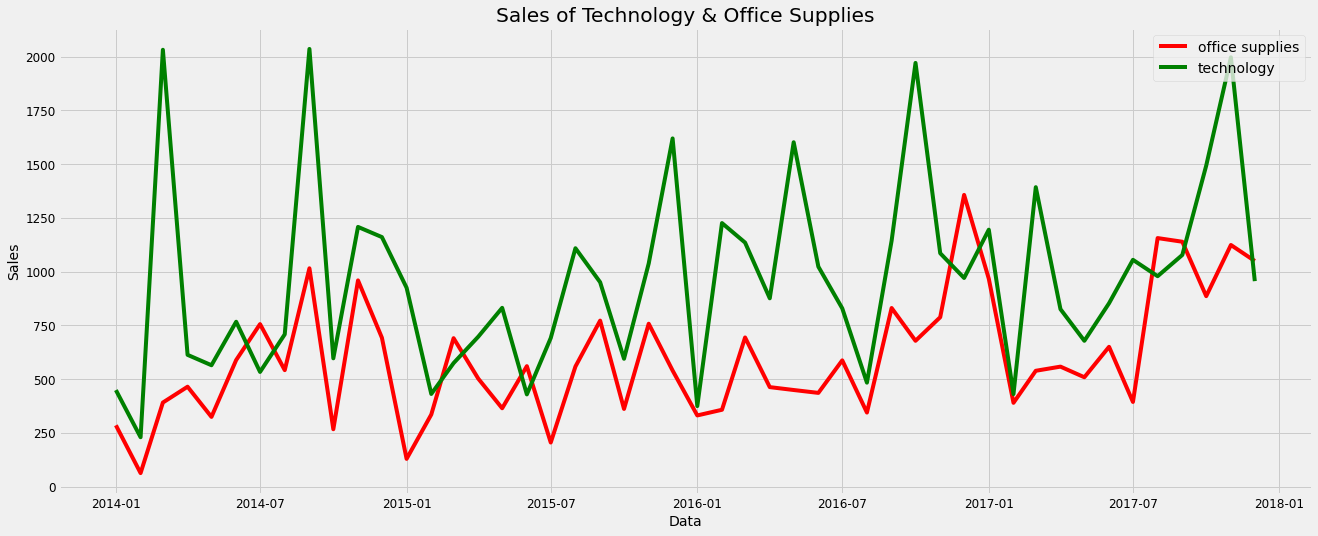

In [ ]:
#So, now we have Office Supplies and Technology.
office = df.loc[df['Category'] == 'Office Supplies']
technology = df.loc[df['Category'] == 'Technology']
office.shape, technology.shape
cols = ['Row ID','Order ID', 'Ship Date', 'Ship Mode', 'Customer ID','Customer Name','Segment','Country','City','State','Postal Code','Region','Product ID',
        'Category','Sub-Category','Product Name','Quantity','Discount','Profit']
office.drop(cols, axis=1, inplace=True)
technology.drop(cols, axis=1, inplace=True)

office = office.sort_values('Order Date')
technology = technology.sort_values('Order Date')
office = office.groupby('Order Date')['Sales'].sum().reset_index()
technology = technology.groupby('Order Date')['Sales'].sum().reset_index()
office = office.set_index('Order Date')
technology = technology.set_index('Order Date')
y_office = office['Sales'].resample('MS').mean()
y_technology = technology['Sales'].resample('MS').mean()

office = pd.DataFrame({'Order Date':y_office.index, 'Sales':y_office.values})
technology = pd.DataFrame({'Order Date':y_technology.index, 'Sales': y_technology.values})

store = technology.merge(office,how= 'inner',on='Order Date')
store.rename(columns={'Sales_x': 'technology_sales','Sales_y': 'office_sales' }, inplace = True)
store.head()

plt.figure(figsize=(20,8))
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office')
plt.plot(store['Order Date'], store['technology_sales'], 'g-', label = 'technology')

plt.xlabel('Data')
plt.ylabel('Sales')
plt.title('Sales of Technology & Office Supplies')
plt.legend(["office supplies","technology"],loc= "upper right")


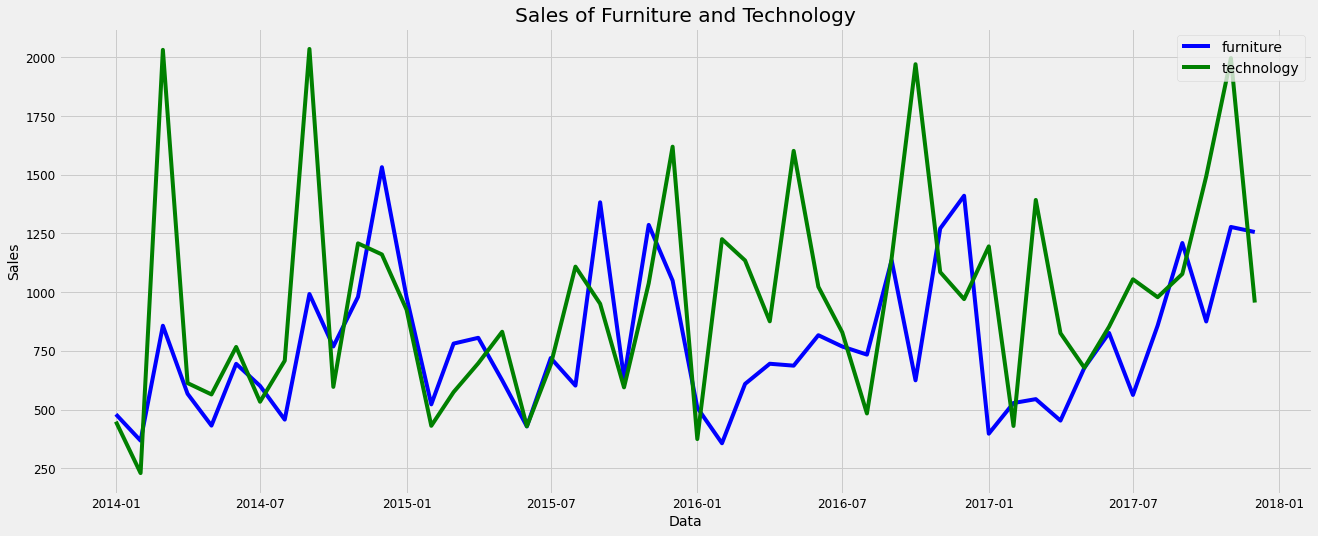

In [ ]:
#Furniture and Technology
furniture = df.loc[df['Category'] == 'Furniture']
technology = df.loc[df['Category'] == 'Technology']
furniture.shape, technology.shape
cols = ['Row ID','Order ID', 'Ship Date', 'Ship Mode', 'Customer ID','Customer Name','Segment','Country','City','State','Postal Code','Region','Product ID',
        'Category','Sub-Category','Product Name','Quantity','Discount','Profit']
furniture.drop(cols, axis=1, inplace=True)
technology.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
technology = technology.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
technology = technology.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
technology = technology.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_technology = technology['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
technology = pd.DataFrame({'Order Date':y_technology.index, 'Sales': y_technology.values})

store = furniture.merge(technology,how= 'inner',on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'technology_sales'}, inplace = True)
store.head()

plt.figure(figsize=(20,8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['technology_sales'], 'g-', label = 'technology')
plt.xlabel('Data')
plt.ylabel('Sales')
plt.title('Sales of Furniture and Technology')
plt.legend(["furniture","technology"],loc= "upper right")


Time Series Modelling with Prophet

In [ ]:
!pip install pystan==2.19
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.2 MB 1.3 MB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.6 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6271797 sha256=497b86e01834097e095e734d3059b2dcd816b0ef9bffa116981b2cbb115e1f6c
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.8
    Uninstalling cmdstanpy-1.0.8:
      Successfully uninstalled cmdstanpy-1.0.8
ERROR: pip's dependency resolver does not currently take into account all the 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Office Supplies Sales')

<Figure size 1296x432 with 0 Axes>

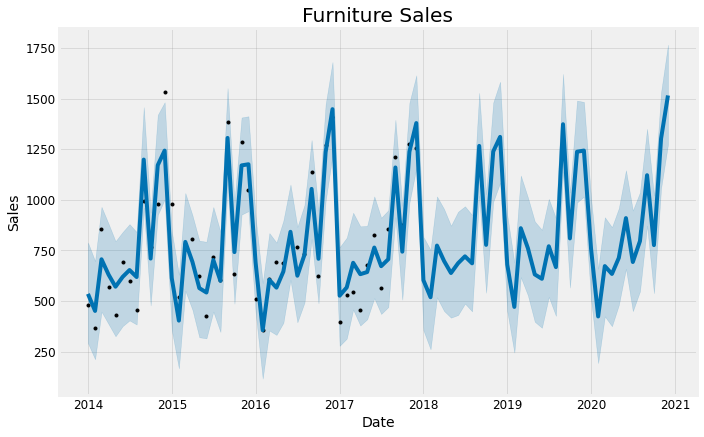

<Figure size 1296x432 with 0 Axes>

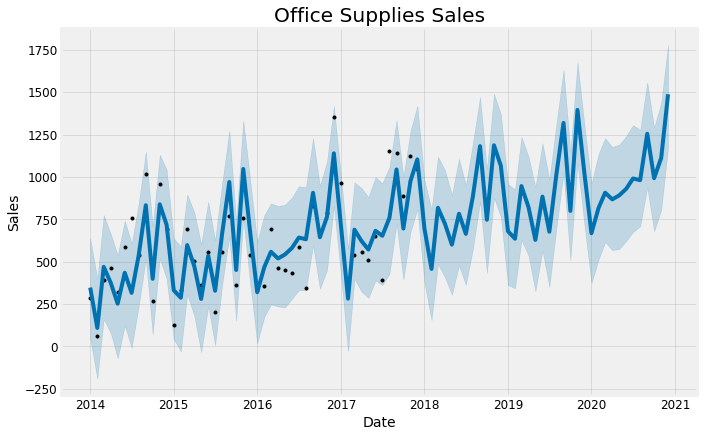

In [ ]:
from fbprophet import Prophet
furniture = furniture.rename(columns={'Order Date':'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width = 0.95)
office_model.fit(office)

technology = technology.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
technology_model = Prophet(interval_width = 0.95)
technology_model.fit(office)


furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

technology_forecast = technology_model.make_future_dataframe(periods=36, freq='MS')
technology_forecast = technology_model.predict(technology_forecast)

plt.figure(figsize=(18,6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales')

plt.figure(figsize=(18,6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales')

In [ ]:
#Comparing Forecast
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]


merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()


merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names


forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')

forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()


,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.057713,292.244161,789.068501,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,...,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,727.494023,212.442055,697.418182,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,...,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,728.791335,447.651150,965.239267,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,...,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,730.227645,385.818245,880.995416,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,...,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,731.617622,325.969527,795.442462,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,...,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


Trend and Forecast Visualization


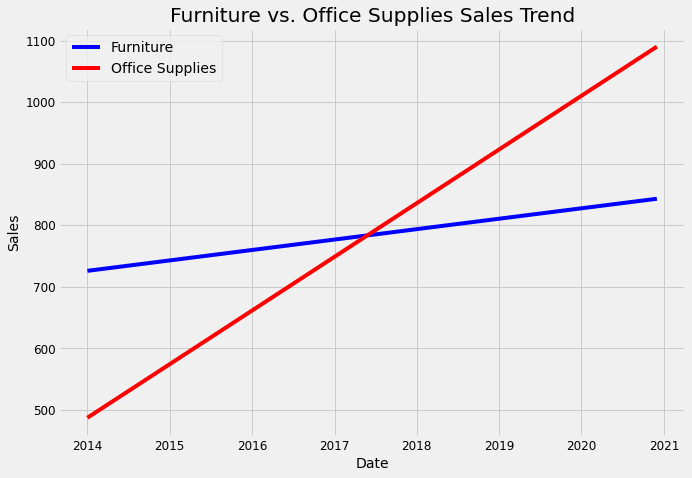

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')

plt.legend(['Furniture','Office Supplies'])
plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

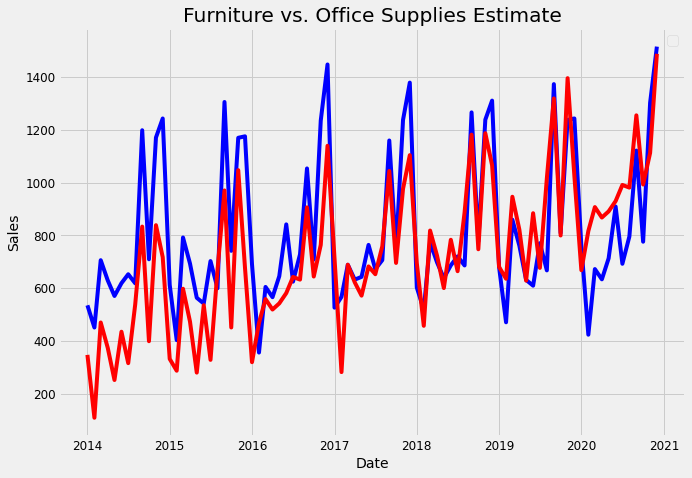

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

Trends and Patterns


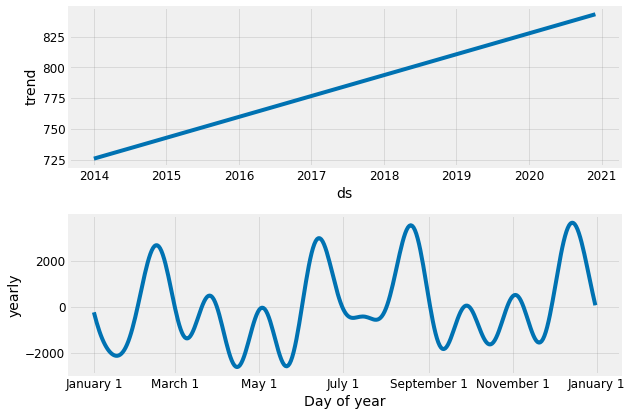

In [ ]:
furniture_model.plot_components(furniture_forecast);

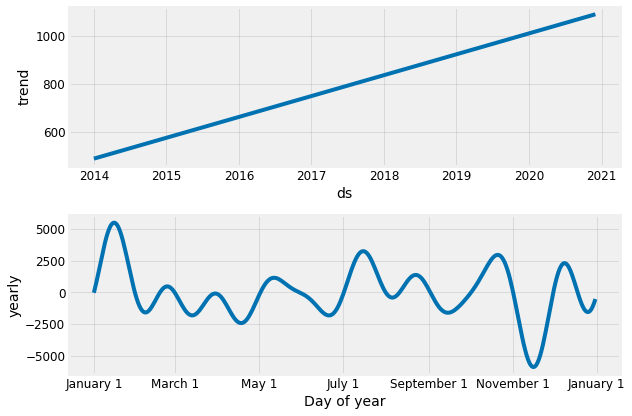

In [ ]:
office_model.plot_components(office_forecast);